In [2]:
from music21 import *
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [1]:
#import torch
#print(torch.__version__)

2.3.0


In [ ]:
#!pip install music21
#import tensorflow as tf


In [ ]:
#!pip install torch torchvision


In [3]:
import pandas as pd
from ast import literal_eval

notes_df = pd.read_csv ('Dataset/notes.csv')
train_df = pd.read_csv ('Dataset/trainset.csv')
validation_df = pd.read_csv ('Dataset/validationset.csv')

data_train = train_df[['x_tr','future']].to_numpy()
data_validation = validation_df[['x_val','future']].to_numpy()

x_tr_string = data_train[:,0]
y_tr_string = data_train[:,1]
x_tr = []
y_tr = []
for i in x_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_tr = [int(j) for j in i.split()]
    x_tr.append(input_x_tr)

for i in y_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_tr = [int(j) for j in i.split()]
    y_tr.append(input_y_tr)
x_tr = np.array(x_tr)
y_tr = np.array(y_tr)
    
# print(x_tr.shape,y_tr.shape)

x_val_string = data_validation[:,0]
y_val_string = data_validation[:,1]
x_val = []
y_val = []
for i in x_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_val = [int(j) for j in i.split()]
    x_val.append(input_x_val)

for i in y_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_val = [int(j) for j in i.split()]
    y_val.append(input_y_val)
x_val = np.array(x_val)
y_val = np.array(y_val)

# print(x_val.shape,y_val.shape)

notes_ = notes_df.to_numpy()[:,1]
unique_notes_reverse = dict(enumerate(notes_.flatten(), 1))
unique_notes = {value : key for (key, value) in unique_notes_reverse.items()}


In [4]:
from MusicDataset import *
batch_size = 8
train_set = MusicDataset(x_tr,y_tr)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [5]:
val_set = MusicDataset(x_val,y_val)
validationloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

**DataLoader**

**For Wavenet Model (Ignore for now)**

In [6]:
from Models import Wavenet,LSTM
# Net = Wavenet.Wavenet(len(unique_notes),blocks=4,layers = 2)
Net = LSTM.Sequence(len(unique_notes),32)
Net.to(device)

Sequence(
  (embedding): Embedding(173, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (softmax): Softmax(dim=None)
  (linear3): Linear(in_features=128, out_features=173, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

**Checking the model**

In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

**Use the line below when you want to change learning parameters in between**

In [8]:
import time , sys
baseDir = ''
expDir = os.path.join(baseDir, 'trained_model_cache', time.strftime("%d_%m_%Y_%H_%M"))
lossDir = os.path.join(expDir, 'loss')
os.makedirs(expDir, exist_ok=True)
os.makedirs(lossDir, exist_ok=True)
print(baseDir,expDir)

 trained_model_cache\14_05_2024_10_20


In [9]:
loss_history = []
best_val_acc = 0
training_mode_list = ["Next_Predict_Mode","Future_Predict_Mode"]
training_mode = "Next_Predict_Mode"
# training_mode = "Future_Predict_Mode"
future_preds = 5

In [11]:
import timeit


''' TRAINING THE MODEL '''
correct_preds = 0
total_preds = 0
for epoch in range(1): 
    running_loss = 0.0
    start = timeit.default_timer()
    for i, data in enumerate(trainloader, 0):
        input , label = data
        optimizer.zero_grad()
        if training_mode == training_mode_list[0]:
            output = Net(input.to(device),input.shape[0])
            loss = criterion(output.to(device), label[:,0].to(device).long())
            loss.backward()
            optimizer.step()
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output,1) == label[:,0].to(device))

            running_loss += loss.item()
        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0,len(unique_notes)).to(device)
            cumm_label  = np.array([],dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device),input.shape[0])
                cumm_output = torch.cat((cumm_output,output))
                cumm_label = np.concatenate((cumm_label,label[:,k]))
                next_preds = np.argmax(output.cpu().detach().numpy(),axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j,next_preds[ind]) 
                                                       for ind,j in enumerate(input)])[:,1:])  
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if (i % 300 == 299  ):
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 300))
            loss_history.append(running_loss/300)
            running_loss = 0.0
    stop = timeit.default_timer()
    print(f"Training Time for Epoch :{epoch} \n {stop-start} seconds\n")
    train_acc =  float(correct_preds)/float(total_preds) *100 
    trainreport ="Training Accuracy : \n correct predictions  : {} \n total predictions : {} \n Training Accuracy : {} \n ------------------------\n".format(correct_preds,total_preds,train_acc)
    print(trainreport)     
    correct_preds = 0
    total_preds = 0
    val_loss = 0
    start = timeit.default_timer()
    for i, data in enumerate(validationloader, 0):
        input , label = data
        if training_mode == training_mode_list[0]:
            output = Net(input.to(device),input.shape[0])
            loss = criterion(output.to(device), label[:,0].to(device).long())
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output,1) == label[:,0].to(device))
            val_loss += loss.item()
            
        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0,len(unique_notes)).to(device)
            cumm_label  = np.array([],dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device),input.shape[0])
                cumm_output = torch.cat((cumm_output,output))
                cumm_label = np.concatenate((cumm_label,label[:,k]))
                next_preds = np.argmax(output.cpu().detach().numpy(),axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j,next_preds[ind]) 
                                                       for ind,j in enumerate(input)])[:,1:])  
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))

            val_loss += loss.item()
    stop = timeit.default_timer()
    print(f"Validation Time for Epoch :{epoch} \n {stop-start} seconds\n")
    val_acc = float(correct_preds)/float(total_preds) *100
    val_loss = float(val_loss)/float(total_preds)
    valreport ="Validation Accuracy : \n correct predictions  : {} \n total predictions : {} \n Val-Loss : {} \n Val-Accuracy :{}----------------------------------\n".format(correct_preds,total_preds,val_loss,val_acc )
    print(valreport)
    
    if(val_acc > best_val_acc):
        print('Updating the model')
        best_val_acc = val_acc
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": Net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_acc": train_acc,
            "valid_acc": val_acc
        }
        torch.save(checkpoint, os.path.join(expDir, 'checkpoint.tar'))
        torch.save(Net, os.path.join(expDir, 'model.pth'))
    
    correct_preds = 0
    total_preds = 0


print('Finished Training')

[1,   300] loss: 4.883
[1,   600] loss: 4.789
[1,   900] loss: 4.774
[1,  1200] loss: 4.758
[1,  1500] loss: 4.769
[1,  1800] loss: 4.755
[1,  2100] loss: 4.764
[1,  2400] loss: 4.796
[1,  2700] loss: 4.774
[1,  3000] loss: 4.740
[1,  3300] loss: 4.736
[1,  3600] loss: 4.747
[1,  3900] loss: 4.716
[1,  4200] loss: 4.759
[1,  4500] loss: 4.746
[1,  4800] loss: 4.756
[1,  5100] loss: 4.646
[1,  5400] loss: 4.615
[1,  5700] loss: 4.583
[1,  6000] loss: 4.610
[1,  6300] loss: 4.627
[1,  6600] loss: 4.601
[1,  6900] loss: 4.589
Training Time for Epoch :0 
 443.97755599999994 seconds

Training Accuracy : 
 correct predictions  : 1236 
 total predictions : 56095 
 Training Accuracy : 2.2034049380515195 
 ------------------------

Validation Time for Epoch :0 
 39.774850000000015 seconds

Validation Accuracy : 
 correct predictions  : 511 
 total predictions : 16028 
 Val-Loss : 0.5730596642587023 
 Val-Accuracy :3.1881707012727722----------------------------------

Updating the model
Finished

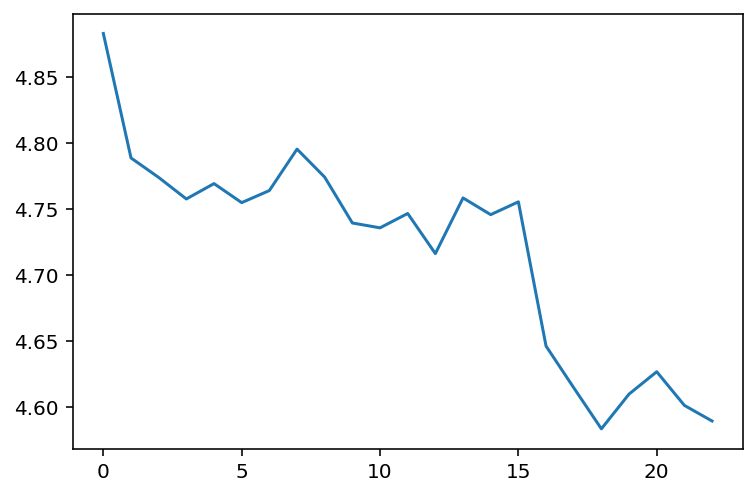

In [12]:
plt.figure()
plt.plot(loss_history)
# plt.savefig(lossDir + '/loss_history.png')

In [13]:
#path='/content/drive/MyDrive/schubert/sine_model.pth'
 #path='/content/drive/MyDrive/schubert/lstmmodel1.pth'
path='schubert/sine_wavenet1.pth'
torch.save(Net.state_dict(), path)

**Testing the Model by training sinosoids**



*   Uncomment the code chunk below to test o sinosoids 
*   dont run above code if training for sinosoids. Variable names are mostly same

